In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

100%|██████████| 169M/169M [00:05<00:00, 28.5MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Model loading functions
def load_alexnet():
    model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 100)
    )
    return model.to(device)

def load_vgg16():
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 100)
    )
    return model.to(device)

In [5]:
# Training and evaluation functions
def train_and_evaluate(model, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

    print(f"\nTraining {model_name}...")
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    start_time = time.time()

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double().cpu().item() / len(train_dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects.double().cpu().item() / len(test_dataset)
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        print(f'Epoch {epoch+1}/10 - Train Loss: {train_loss[-1]:.4f} Acc: {train_acc[-1]:.4f} | Val Loss: {val_loss[-1]:.4f} Acc: {val_acc[-1]:.4f}')

    train_time = time.time() - start_time

    # Inference time
    start_time = time.time()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            _ = model(images)
    inference_time = (time.time() - start_time) / len(test_dataset) * 1000  # ms per sample

    # Test accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().cpu().item()
    test_accuracy = 100 * correct / total

    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'test_accuracy': test_accuracy,
        'train_time': train_time,
        'inference_time': inference_time,
        'val_acc': val_acc[-1]
    }

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 200MB/s] 



Training AlexNet...
Epoch 1/10 - Train Loss: 2.4654 Acc: 0.3738 | Val Loss: 1.6868 Acc: 0.5284
Epoch 2/10 - Train Loss: 1.5866 Acc: 0.5564 | Val Loss: 1.4884 Acc: 0.5853
Epoch 3/10 - Train Loss: 1.3253 Acc: 0.6207 | Val Loss: 1.4063 Acc: 0.6022
Epoch 4/10 - Train Loss: 1.1400 Acc: 0.6685 | Val Loss: 1.3699 Acc: 0.6123
Epoch 5/10 - Train Loss: 0.9761 Acc: 0.7098 | Val Loss: 1.3355 Acc: 0.6256
Epoch 6/10 - Train Loss: 0.8379 Acc: 0.7475 | Val Loss: 1.3216 Acc: 0.6299
Epoch 7/10 - Train Loss: 0.7258 Acc: 0.7779 | Val Loss: 1.3291 Acc: 0.6310
Epoch 8/10 - Train Loss: 0.6130 Acc: 0.8095 | Val Loss: 1.3434 Acc: 0.6355
Epoch 9/10 - Train Loss: 0.5399 Acc: 0.8306 | Val Loss: 1.3811 Acc: 0.6347
Epoch 10/10 - Train Loss: 0.4679 Acc: 0.8517 | Val Loss: 1.3543 Acc: 0.6372


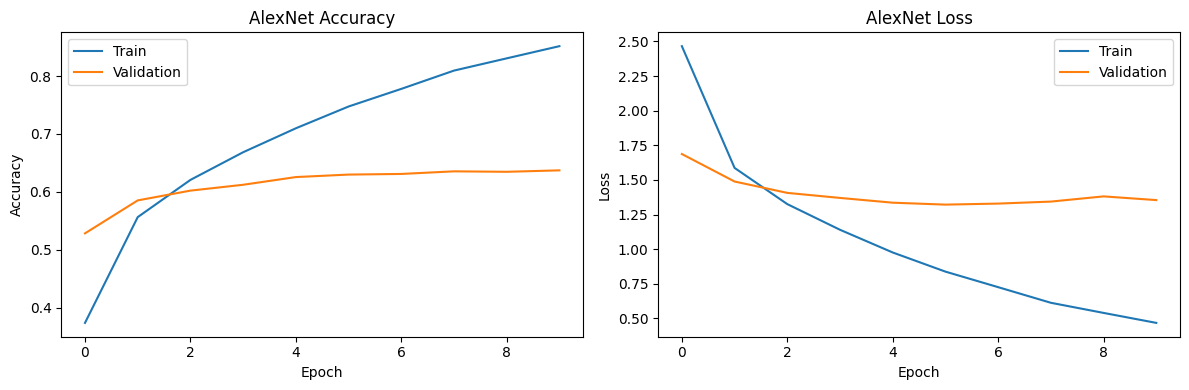

In [6]:
# Train and evaluate AlexNet
alexnet_results = train_and_evaluate(load_alexnet(), "AlexNet")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 202MB/s] 



Training VGG16...
Epoch 1/10 - Train Loss: 2.2268 Acc: 0.4205 | Val Loss: 1.3886 Acc: 0.5991
Epoch 2/10 - Train Loss: 1.1107 Acc: 0.6753 | Val Loss: 1.2419 Acc: 0.6380
Epoch 3/10 - Train Loss: 0.6464 Acc: 0.8091 | Val Loss: 1.2144 Acc: 0.6555
Epoch 4/10 - Train Loss: 0.3309 Acc: 0.9053 | Val Loss: 1.2452 Acc: 0.6632
Epoch 5/10 - Train Loss: 0.1698 Acc: 0.9538 | Val Loss: 1.2968 Acc: 0.6675
Epoch 6/10 - Train Loss: 0.0984 Acc: 0.9755 | Val Loss: 1.3994 Acc: 0.6661
Epoch 7/10 - Train Loss: 0.0697 Acc: 0.9827 | Val Loss: 1.4442 Acc: 0.6603
Epoch 8/10 - Train Loss: 0.0560 Acc: 0.9858 | Val Loss: 1.4920 Acc: 0.6623
Epoch 9/10 - Train Loss: 0.0507 Acc: 0.9878 | Val Loss: 1.5438 Acc: 0.6590
Epoch 10/10 - Train Loss: 0.0500 Acc: 0.9870 | Val Loss: 1.6184 Acc: 0.6508


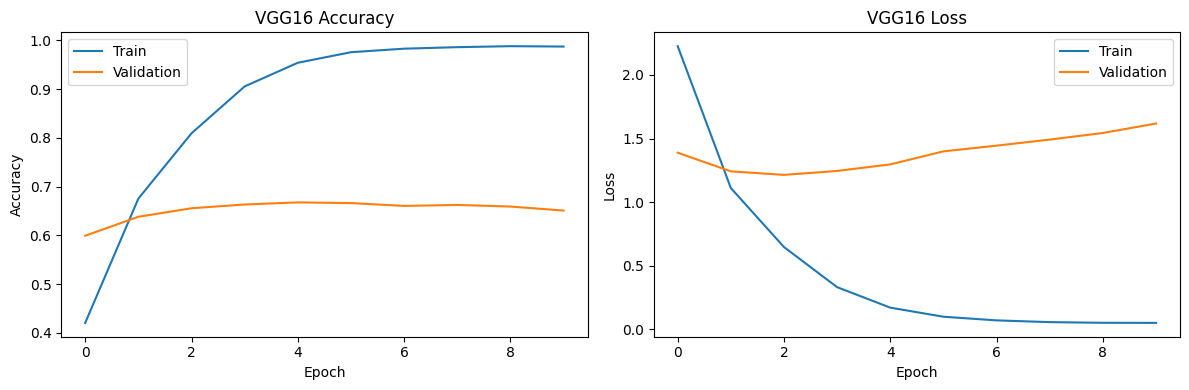

In [7]:
# Train and evaluate VGG16
vgg16_results = train_and_evaluate(load_vgg16(), "VGG16")


Model Comparison:
Metric              AlexNet   VGG16     
Test Accuracy (%)   63.72     65.08     
Val Accuracy        0.6372    0.6508    
Training Time (s)   568.00    1624.93   
Inference Time (ms) 0.9425    2.5762    


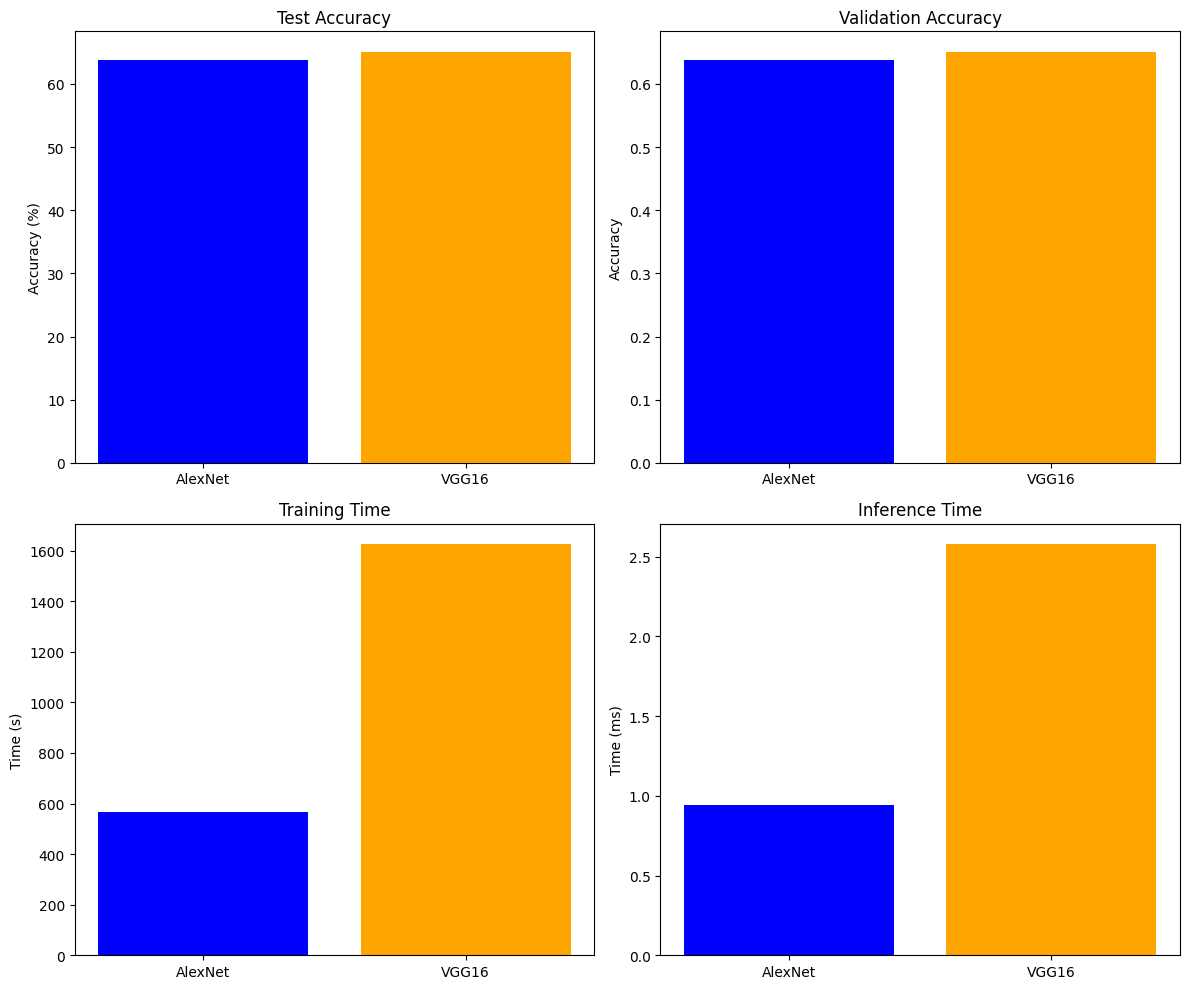

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Comparison
print("\nModel Comparison:")
print(f"{'Metric':<20}{'AlexNet':<10}{'VGG16':<10}")
print(f"{'Test Accuracy (%)':<20}{alexnet_results['test_accuracy']:<10.2f}{vgg16_results['test_accuracy']:<10.2f}")
print(f"{'Val Accuracy':<20}{alexnet_results['val_acc']:<10.4f}{vgg16_results['val_acc']:<10.4f}")
print(f"{'Training Time (s)':<20}{alexnet_results['train_time']:<10.2f}{vgg16_results['train_time']:<10.2f}")
print(f"{'Inference Time (ms)':<20}{alexnet_results['inference_time']:<10.4f}{vgg16_results['inference_time']:<10.4f}")

# Data for comparison
metrics = ['Test Accuracy', 'Validation Accuracy', 'Training Time', 'Inference Time']
alexnet_values = [
    alexnet_results['test_accuracy'],
    alexnet_results['val_acc'],
    alexnet_results['train_time'],
    alexnet_results['inference_time']
]
vgg16_values = [
    vgg16_results['test_accuracy'],
    vgg16_results['val_acc'],
    vgg16_results['train_time'],
    vgg16_results['inference_time']
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Test Accuracy
axs[0, 0].bar(['AlexNet', 'VGG16'], [alexnet_results['test_accuracy'], vgg16_results['test_accuracy']], color=['blue', 'orange'])
axs[0, 0].set_title('Test Accuracy')
axs[0, 0].set_ylabel('Accuracy (%)')

# Plot Validation Accuracy
axs[0, 1].bar(['AlexNet', 'VGG16'], [alexnet_results['val_acc'], vgg16_results['val_acc']], color=['blue', 'orange'])
axs[0, 1].set_title('Validation Accuracy')
axs[0, 1].set_ylabel('Accuracy')

# Plot Training Time
axs[1, 0].bar(['AlexNet', 'VGG16'], [alexnet_results['train_time'], vgg16_results['train_time']], color=['blue', 'orange'])
axs[1, 0].set_title('Training Time')
axs[1, 0].set_ylabel('Time (s)')

# Plot Inference Time
axs[1, 1].bar(['AlexNet', 'VGG16'], [alexnet_results['inference_time'], vgg16_results['inference_time']], color=['blue', 'orange'])
axs[1, 1].set_title('Inference Time')
axs[1, 1].set_ylabel('Time (ms)')

# Adjust layout
plt.tight_layout()
plt.show()
